In [1]:
# slected image path
# put the image to the terminal, and the terminal will show its full path
selected_path = '../model_example/96a26f9f-76b9-456a-b39f-d390ff20bc58___FREC_Scab 3257_50-50_classified_right_50-50_label_1_pred_1.jpg'
# the directory path which directly contains the saved model
# this is the same as `--saveroot`  you set in the `.sh` files
model_dir='../model_example'

In [2]:
from __future__ import print_function, division
import argparse
import torch
from torch.nn import functional as F
from torchvision import models
import matplotlib.pyplot as plt
import os
import sys
import random
import cv2
from get_result_file_paths import get_result_file_paths
from ResNet18Model import ResNet18FC
from resnet18_run import share_parser
from visual_tools import guided_gradcam, make_grid
if sys.version_info[0] == 2:
    import cPickle as pickle
else:
    import pickle
%matplotlib inline

In [3]:
parser = share_parser()
args = parser.parse_args([])
#https://stackoverflow.com/questions/41961949/google-oauth-inside-jupyter-notebook
assert args.train_size >= args.batch_size

In [ ]:
args.cuda = not args.no_cuda and torch.cuda.is_available()
print(args.cuda)
print(args)

In [5]:
if args.seed is None:
    args.seed = random.randint(1, 10000)
print("Random Seed: ", args.seed)
random.seed(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed_all(args.seed)
    torch.backends.cudnn.benchmark = True

Random Seed:  5306


In [6]:
kwargs = {'num_workers': 2, 'pin_memory': True} if args.cuda else {}
data_separate = '50-50'#args.dataseparate

In [7]:
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

In [8]:
args.arch = 'resnet18'
model = models.__dict__[args.arch]() #pretrained=True
model.eval()
distilled_model = ResNet18FC(model)
#checkpoint_fn = os.path.join(args.saveroot, args.dataset+'_'+args.arch+'_'+str(29)+'_distilled_'+save_model_per_epoch_suffix)
#state_dict = torch.load(checkpoint_fn)
#print('load %s ' % checkpoint_fn)
#distilled_model.load_state_dict(state_dict['state_dict'])
distilled_model.eval()
if args.cuda:
    distilled_model = torch.nn.DataParallel(distilled_model).cuda()
del model

In [9]:
fo = open(os.path.join(args.dataroot,data_separate,'labels.txt'), 'r')
classes = []
for l in fo:
    classes.append(l.split('\n')[0])
fo.close()
classes_to_ind_dict = {}
for i, cla in enumerate(classes):
    classes_to_ind_dict[cla] = i

loading ../model_example/leaf_resnet18_29_MSErealdistilled_50-50_checkpoint_lr_0.0006_wd_0.0005_no_weights.pth.tar 
load ../model_example/leaf_resnet18_29_MSErealdistilled_50-50_checkpoint_lr_0.0006_wd_0.0005_no_weights.pth.tar 
../model_example/96a26f9f-76b9-456a-b39f-d390ff20bc58___FREC_Scab 3257_50-50_classified_right_50-50_label_1_pred_1.jpg
cam
[[ 26  26  26 ...  47  47  47]
 [ 26  26  26 ...  47  47  47]
 [ 26  26  26 ...  47  47  47]
 ...
 [131 131 131 ...  74  74  74]
 [131 131 131 ...  74  74  74]
 [131 131 131 ...  74  74  74]]
camplus
[[ 34  34  34 ...  60  60  60]
 [ 34  34  34 ...  60  60  60]
 [ 34  34  34 ...  60  60  60]
 ...
 [136 136 136 ...  86  86  86]
 [136 136 136 ...  86  86  86]
 [136 136 136 ...  86  86  86]]
Grad cam completed
Guided backpropagation completed
Guided grad cam completed
Guided grad cam++ completed
predict: Apple___Apple_scab; probability: 0.995190


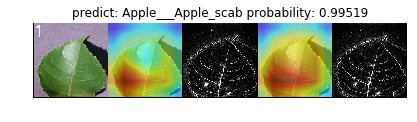

In [10]:
# draw the system preview resnet18 visualization
logits_dir=''
archname='resnet18'
has_weights='False'
is_soft_target='False'
is_distilled='MSETrue'
data_type='test'
epoch = 29
lr = 0.0006
if archname == 'resnet18':
    target_layer = 'layer4/1/relu'
elif archname == 'resnet101':
    target_layer = 'layer4/2/relu'
result_imgs = []
predict_list = []
target_list = []
prob_list = []

for data_separate in ['50-50']: #'10-90', 
    model_path, preds_labels_file = get_result_file_paths(epoch, lr, args.wd, args.dataset, data_separate, archname, data_type, has_weights, logits_dir=logits_dir, model_dir=model_dir, is_soft_target=is_soft_target, is_distill=is_distilled)
    print('loading %s ' % model_path)
    state_dict = torch.load(model_path)['state_dict']
    print('load %s ' % model_path)
    distilled_model.load_state_dict(state_dict)
    distilled_model.eval()

    img_with_gradcam_heatmap, img_with_gradcamplus_heatmap, original_image, grayscale_cam_gb_img, grayscale_cam_gb_plus_img, predic_ind, target_class, model_out, _=guided_gradcam(distilled_model,target_layer, img_dataset_loader=None, batch_ind=None, img_ind=None, base_model=None, draw_feature_num=7, draw_acc_pred=True, data_sep=data_separate, given_img_path=selected_path, classes_to_ind_dict=classes_to_ind_dict, usecuda=args.cuda, has_target_labels=False)
    grayscale_cam_gb_img = grayscale_cam_gb_img.unsqueeze(dim=0)
    grayscale_cam_gb_plus_img = grayscale_cam_gb_plus_img.unsqueeze(dim=0)
    grayscale_cam_gb_img = torch.cat((grayscale_cam_gb_img, grayscale_cam_gb_img, grayscale_cam_gb_img), 0)
    grayscale_cam_gb_plus_img = torch.cat((grayscale_cam_gb_plus_img, grayscale_cam_gb_plus_img, grayscale_cam_gb_plus_img), 0)
    #result_imgs.extend([original_image, img_with_gradcam_heatmap, img_with_gradcamplus_heatmap])
    result_imgs.extend([original_image, img_with_gradcam_heatmap, grayscale_cam_gb_img, img_with_gradcamplus_heatmap, grayscale_cam_gb_plus_img])
    predict_list.append(predic_ind)
    if target_class is not None:
        target_list.append(target_class)
    else:
        target_list = None

    pred_prob = F.softmax(model_out.cpu(), dim=1).data.max()
    pred_prob = float("{0:.5f}".format(pred_prob))
    if target_class is not None:
        print('predict: %s / label: %s; probability: %f' % (classes[predic_ind], classes[target_class], pred_prob ))
    else:
        print('predict: %s; probability: %f' % (classes[predic_ind], pred_prob ))
    prob_list.append(pred_prob)
out = make_grid(result_imgs, nrow=5, pad_value=0, predict_list=predict_list, target_list=target_list, prob_list=prob_list, write_prob=False)
out = out.numpy()#.transpose(1,2,0)
fig = plt.figure()
plt.title('predict: '+classes[predic_ind]+' probability: '+str(pred_prob)+'')
plt.axis('off')
fig.set_size_inches(cm2inch(17,15))
plt.imshow(cv2.cvtColor(out,cv2.COLOR_BGR2RGB)) #
plt.pause(0.001)
pred_prob = F.softmax(model_out.cpu(), dim=1).data.max()
pred_prob = float("{0:.5f}".format(pred_prob))

In [11]:
fig.savefig(os.path.join('/home/h/Documents/bmc_template/images','test_results_w2.pdf'), bbox_inches='tight')#, pad_inches=0.5#, dpi=fig.dpi